# CALCULO_AJUSTES_COMSOL 
Calcula los ajustes de scattering de clusters y vesículas usando los datos de Comsol
2018 Infor, AOCG

In [1]:
from __future__ import print_function, division

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

%config InlineBackend.figure_format = 'png'

from pprint import  pprint

In [2]:
from phyton_optics import sp, plt, mm, um, nm, degrees
from scipy import linspace

In [3]:
# Parámetros generales
r = linspace(20*nm,200*nm,19); # Radio del cluster (nm)
c = linspace(0.1,0.5,21) # Concentración volumétrica relativa
[R,C] = sp.meshgrid(r,c);


## Calculo de vesiculas (solo dependen de la concentración)
### Scattering cross section vesiculas

In [65]:
def vesicles_cross_section(c):
    """Sección eficaz en m2"""
    
    # Parámetros
    Sv1 = 1.89802e-12
    Sv2 = -7.44055e-12
    Sv3 = 5.77093e-12
    Sv = Sv1*c**2+Sv2*c+Sv3
    return Sv

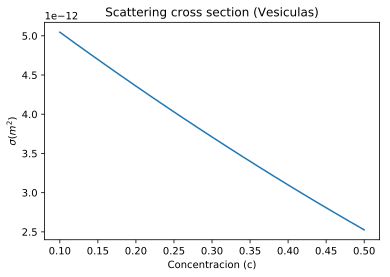

In [66]:
plt.plot(c,vesicles_cross_section(c));
plt.title('Scattering cross section (Vesiculas)');
plt.xlabel('Concentracion (c)');
plt.ylabel('$\sigma (m^2)$');

### Coeficiente asimetria vesiculas

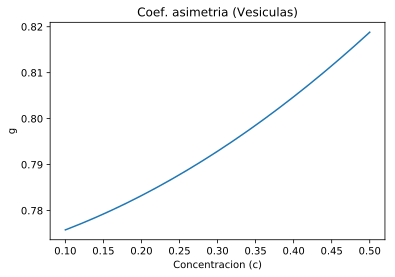

In [67]:
def vesicles_asymmetry_coefficent(c):
    """coeficiente de asimetria"""
    #Parametros
    gv1 = 0.109884;
    gv2 = 0.041627;
    gv3 = 0.770523;
    g = gv1*c**2+gv2*c+gv3;
    return g
    
plt.plot(c,vesicles_asymmetry_coefficent(c));
plt.title('Coef. asimetria (Vesiculas)');
plt.xlabel('Concentracion (c)');
plt.ylabel('g');

## Calculo para clusters (dependen del radio y concentracion)
### Calculo del scattering cross-section (vesiculas)

In [68]:
def clusters_cross_section(c, radius):
    radius = radius/nm
    Sp00 = 1.24e-15;
    Sp10 = 2.577e-15;
    Sp01 = -5.059e-16;
    Sp20 = 2.153e-15;
    Sp11 = -1.162e-15;
    Sp02 = 5.071e-17;
    Sp30 = 8.025e-16;
    Sp21 = -1.055e-15;
    Sp12 = 1.834e-16;
    Sp40 = 9.334e-17;
    Sp31 = -3.366e-16;
    Sp22 = 1.102e-16;

    # Parametros normalizados (necesarios para Cross Section)
    rcm = 112.5;
    rcstd = 51.95;
    Rn = (radius-rcm)/rcstd;
    clocm = 0.35;
    clocstd = 0.08805;
    Cn = (c-clocm)/clocstd;

    # Calculo del scattering  cross section (como lo hago en la dll)
    Stemp = Sp40;
    Stemp = Stemp*Rn + Sp31*Cn + Sp30;
    Stemp = Stemp*Rn + Sp22*Cn**2 + Sp21*Cn + Sp20;
    Stemp = Stemp*Rn + Sp12*Cn**2 + Sp11*Cn + Sp10;
    Stemp = Stemp*Rn + Sp02*Cn**2 + Sp01*Cn + Sp00;
    Sc = Stemp;
    
    return Sc

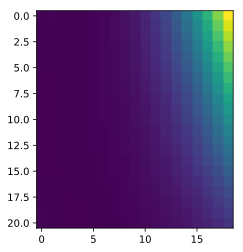

In [69]:
Sc = clusters_cross_section(C,R)
plt.imshow(Sc);


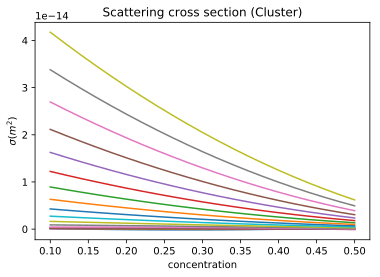

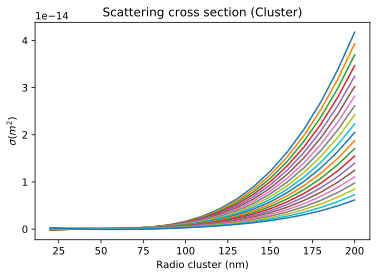

In [70]:
# Representacion resultados
plt.plot(c,Sc);
plt.title('Scattering cross section (Cluster)');
plt.xlabel('concentration');
plt.ylabel('$\sigma (m^2)$');

plt.figure()
plt.plot(r/nm,Sc.transpose());
plt.title('Scattering cross section (Cluster)');
plt.xlabel('Radio cluster (nm)');
plt.ylabel('$\sigma (m^2)$');

#cv = c[::5];
#text = cell(1,length(cv));
#for k in range(len(cv)):
#    text{k} = ['c = ' num2str(cv(k),3)];
#end
#plt.legend(text);

### Calcula el coeficiente  de asimetria (clusters)
Parameters for computing the anisotropy coefficient (fromn Alex's Comsol simulations)*/

In [71]:
def clusters_asymmetry_coefficent(c, radius):
    radius = radius/nm

    """coeficiente de asimetria"""
    gp00 = -0.01276;
    gp10 = -0.001197;
    gp01 = -0.04586;
    gp20 = 8.628e-5;
    gp11 = 0.00237;
    gp02 = 0.01374;
    gp30 = -3.046e-7;
    gp21 = -9.82e-6;
    gp12 = -0.0002186;

    # Computing the anysotropy coefficient*/
    gtemp = gp30;
    gtemp = gtemp*radius + gp20 + gp21*c;
    gtemp = gtemp*radius + gp10 + gp11*c + gp12*(c**2);
    gtemp = gtemp*radius + gp00 + gp01*c + gp02*(c**2);
    
    return gtemp

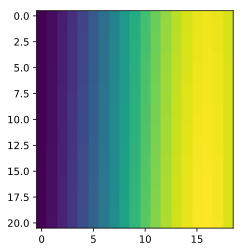

In [72]:
cac = clusters_asymmetry_coefficent(C,R)
plt.imshow(cac);

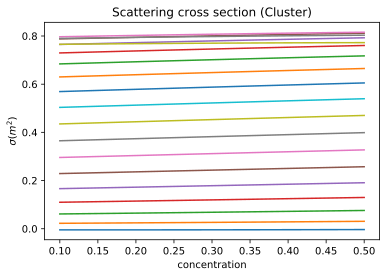

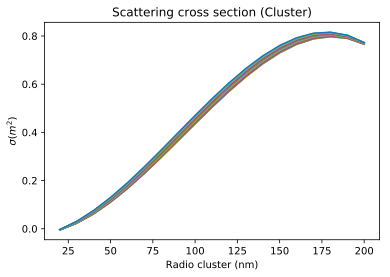

In [73]:
# Representacion resultados
plt.plot(c,cac);
plt.title('Scattering cross section (Cluster)');
plt.xlabel('concentration')
plt.ylabel('$\sigma (m^2)$');

plt.figure()
plt.plot(r/nm,cac.transpose());
plt.title('Scattering cross section (Cluster)');
plt.xlabel('Radio cluster (nm)');
plt.ylabel('$\sigma (m^2)$');

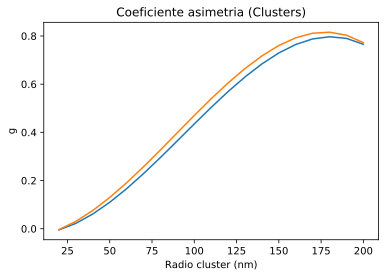

In [74]:
# Representación gráfica
plt.plot(r/nm,cac[0,:],r/nm,cac[-1,:]);
plt.title('Coeficiente asimetria (Clusters)');
plt.xlabel('Radio cluster (nm)');
plt.ylabel('g');

In [81]:
def scattering_coefficient(c, radius, N, kind):
    """
    ec 4 art. infor
    
    Args:
        c (float): concentration
        radius (float): radius
        N: concentración volumétrica (partíclas por unidad de volumen)
        kind (str): 'vesicles' or 'clusters'
    """
    
    if kind == 'clusters':
        sigma=clusters_cross_section(c, radius)
    elif kind == 'vesicles':
        sigma=vesicles_cross_section(c)
    else:
        print("error in scattering_coefficient")
    
    return sigma * N


def mean_free_path(c, radius, N, kind):
    """
    ec 4 art. infor
    
    Args:
        c (float): concentration
        radius (float): radius
        N: concentración volumétrica (partíclas por unidad de volumen)
        kind (str): 'vesicles' or 'clusters'
    """
    return 1/scattering_coefficient(c, radius, N, kind)
    
    
    
def phase_function(theta, g, draw=False):
    """
    Henyey-Greenstein scattering phase function
    
    Args:
        theta (float): angles
        g: asymmetric coefficent
    """
    if g==1:
        g=0.9999
        
    p= (1-g**2)/(4*sp.pi*(1+g**2-2*g*sp.cos(theta))**1.5)
    
    if draw is True:
        theta=sp.linspace(0,2*sp.pi,361)
        plt.figure()
        plt.polar(theta,(1-g**2)/(4*sp.pi*(1+g**2-2*g*sp.cos(theta))**1.5))
        # plt.plot(theta,(1-g**2)/(4*sp.pi*(1+g**2-2*g*sp.cos(theta))**1.5))

    return p

29.11771903548308 198.46635186357594


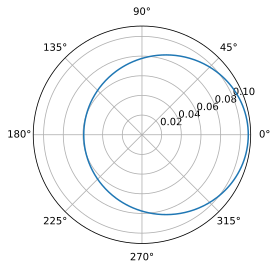

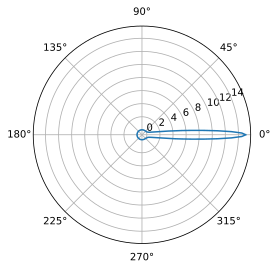

In [82]:

p1=phase_function(theta, g=0.1, draw=True)
p2=phase_function(theta, g=0.9, draw=True)

print(p1.sum(), p2.sum())

In [106]:
def reduced_scattering_coefficient(c, radius, N, kind):
    """
    ec 4 art. infor
    
    Args:
        c (float): concentration
        radius (float): radius
        N: concentración volumétrica (partíclas por unidad de volumen)
        kind (str): 'vesicles' or 'clusters'
    """
    sc= scattering_coefficient(c, radius, N, kind)
    if kind == 'clusters':
        g=clusters_asymmetry_coefficent(c, radius)
    elif kind == 'vesicles':
        g=vesicles_asymmetry_coefficent(c)
        
    return sc*(1-g)

def reduced_mean_free_path(c, radius, N, kind):
    """
    ec 4 art. infor
    
    Args:
        c (float): concentration
        radius (float): radius
        N: concentración volumétrica (partíclas por unidad de volumen)
        kind (str): 'vesicles' or 'clusters'
    """
    return 1/reduced_scattering_coefficient(c, radius, N, kind)
    

In [107]:
reduced_mean_free_path(c=0.5, radius=20*nm, N=1e9, kind='clusters')

3314960.543863458

In [118]:

# (normal eye)
r0= 26*nm  # average cluster radius
d0=1778*nm # cluster distance
Nv=23250   # vesicle concentration mm**-3
In=100     # ???

#cataratas
r0= 34*nm  # average cluster radius
d0=1788*nm  # cluster distance
Nv=76500   # vesicle concentration mm**-3
In=85      # ???


Nc=sp.sqrt(2)/d0**3 # d is the distance between clusters


In [119]:
Nc

0.24740726848367942

In [120]:
Nv

76500

In [121]:
reduced_mean_free_path(c=0.5, radius=90*nm, N=Nv, kind='vesicles')

28569947.7686287

In [122]:
reduced_mean_free_path(c=0.5, radius=r0, N=Nc/(nm)**3, kind='clusters')

74415775.12593444